In [1]:
import cirq
from cirq.contrib.svg import SVGCircuit
import numpy as np

from qualtran._infra.gate_with_registers import get_named_qubits
from qualtran.bloqs.qubitization_walk_operator_test import get_walk_operator_for_1d_ising_model
from qualtran import drawing

/Users/stefano/git_repositories/forks/Qualtran/.conda/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


# Ising walk from test

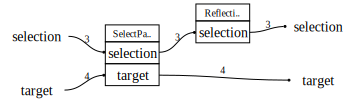

In [2]:
num_sites: int = 4
eps: float = 1e-5
m_bits: int = 14

walk = get_walk_operator_for_1d_ising_model(num_sites, eps)
drawing.show_bloq(walk.decompose_bloq())

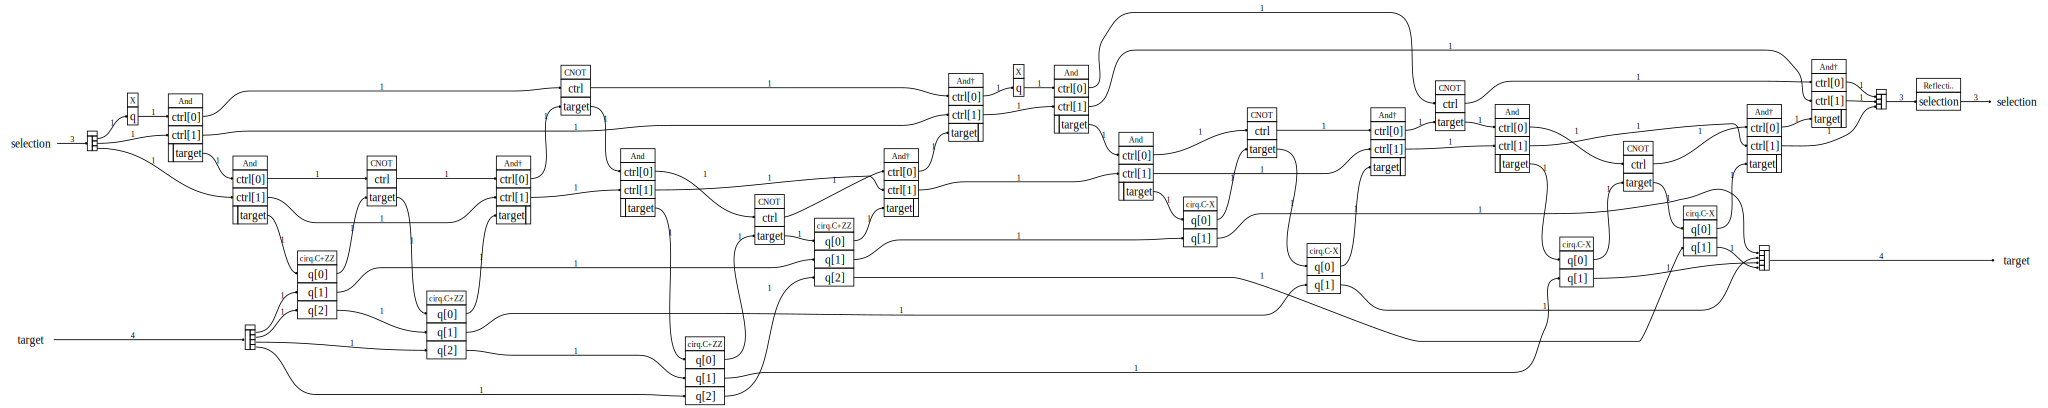

In [5]:
from qualtran.bloqs.qubitization_walk_operator_test import SelectPauliLCU
from qualtran.bloqs.qubitization_walk_operator import ReflectionUsingPrepare
from qualtran.bloqs.state_preparation import StatePreparationAliasSampling
from qualtran._infra.adjoint import Adjoint
from qualtran.bloqs.mcmt import And

bloq_types_to_decompose = (SelectPauliLCU)#, ReflectionUsingPrepare, StatePreparationAliasSampling)

def check(binst):
    b = binst.bloq
    if isinstance(b, Adjoint):
        b = b.subbloq
    if isinstance(b, bloq_types_to_decompose):
        return True
    else:
        return binst.bloq.supports_decompose_bloq()

walk_flattened = walk.decompose_bloq().flatten(check)
drawing.show_bloq(walk_flattened)

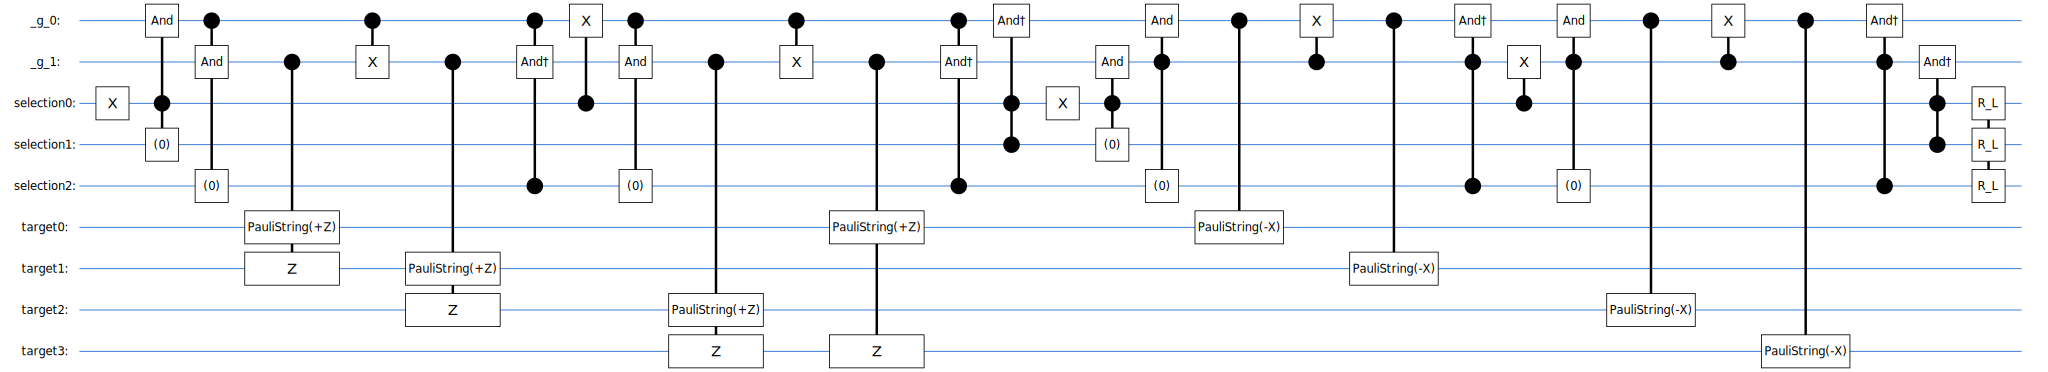

In [6]:
quregs = get_named_qubits(walk_flattened.signature)
qubit_manager = cirq.ops.greedy_qubit_manager.GreedyQubitManager('_g')

circuit, _ = walk_flattened.to_cirq_circuit(**quregs, qubit_manager=qubit_manager)
SVGCircuit(circuit)

# improved Ising

In [72]:
from cirq.ops.greedy_qubit_manager import GreedyQubitManager

In [77]:
from qualtran.bloqs.chemistry.ising import get_1d_ising_hamiltonian

def get_ising_chain_select(num_sites):
    ham = get_1d_ising_hamiltonian(qubits=cirq.LineQubit.range(num_sites))
    q = sorted(ham.qubits)
    ham_dps = [ps.dense(q) for ps in ham]
    selection_reg_size = int(np.ceil(np.log2(len(ham_dps))))

    select = SelectPauliLCU(
        selection_reg_size, select_unitaries=ham_dps, target_bitsize=len(q)
    )
    return select


In [78]:
num_sites = 4
select = get_ising_chain_select(num_sites)
drawing.show_bloqs([select, select.decompose_bloq()])

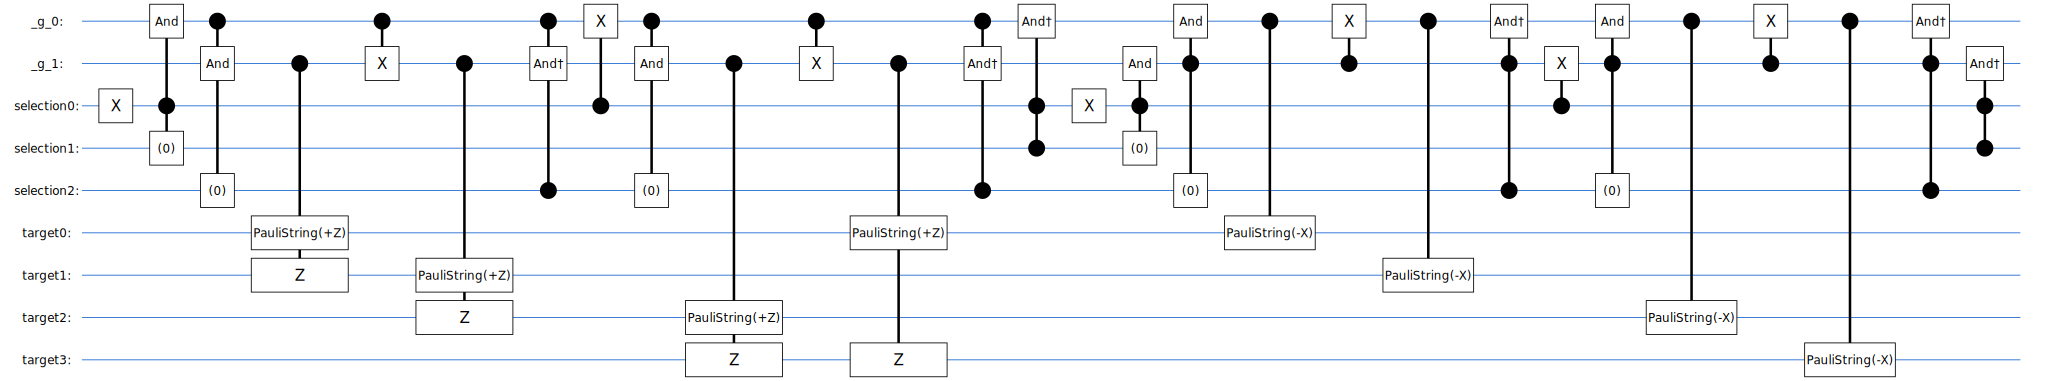

In [79]:
qubit_manager = GreedyQubitManager('_g')
quregs = get_named_qubits(select.signature)
select_circuit, _ = select.decompose_bloq().to_cirq_circuit(qubit_manager, **quregs)
SVGCircuit(select_circuit)

In [81]:
from qualtran.bloqs.state_preparation.prepare_uniform_superposition import PrepareUniformSuperposition

prepare = PrepareUniformSuperposition(num_sites*2)
drawing.show_bloqs([prepare, prepare.decompose_bloq()])